In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('data/get_movies.pkl', 'rb') as f:
    t = pickle.load(f)
    
movie_dic = t[0]
movie_genre_dic = t[1]

with open('data/get_ratings.pkl', 'rb') as f:
    lst = pickle.load(f)

In [3]:
def grad_U(Ui, Yij, Vj, y_mean, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-2*reg*eta)*Ui + 2 * eta * Vj * (Yij - y_mean - np.dot(Ui,Vj))     

def grad_V(Vj, Yij, Ui, y_mean, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-2*reg*eta)*Vj + 2 * eta * Ui * (Yij - y_mean - np.dot(Ui,Vj))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += (Yij - y_mean - np.dot(U[i-1], V[:,j-1]))**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += reg * (U_frobenius_norm ** 2)
        err += reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def get_msqe_err(U, V, Y):
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    err = 0.0
    for (i,j,Yij) in Y:
        err += (Yij - y_mean - np.dot(U[i-1], V[:,j-1]))**2
    
    err /= len(Y)
    
    return err ** 0.5

def train_model(M, N, K, eta, reg, Y, Y_test):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    
    best_test_error = float('inf')
    
    size = len(Y)
    delta = None
    indices = np.arange(size)    
    epoch = 0

    
    while True:
        epoch += 1
        
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, reg)
        np.random.shuffle(indices)
        
        prev_U = U.copy()
        prev_V = V.copy()
        
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], y_mean, reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], y_mean, reg, eta);
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, reg)
        E_out = get_msqe_err(U, V, Y_test)

        print("Epoch %s, E_in (regularized MSE): %s; E_out (MSQE): %s"%(epoch, E_in, E_out))
#         print("Epoch %s, E_in (regularized MSE): %s; MSQE: %s"%(epoch + 1, E_in, get_msqe_err(U, V, Y)))


        if best_test_error > E_out:
            best_test_error = E_out
        else:
            return (prev_U, prev_V, get_msqe_err(prev_U, prev_V, Y), get_msqe_err(prev_U, prev_V, Y_test), epoch - 1)

#     return (U, V, get_err(U, V, Y,y_mean))
    return -1

In [4]:
ratings = np.array(lst)

# train/test

In [5]:
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

In [6]:
num_movies = len(movie_dic)
num_users = 943
m = num_users
n = num_movies
k = 20
eta = 0.005
reg = 0.02

# u,v, final_err, y_mean = train_model(m, n, k, eta, reg, Y_train, eps=0.0001, max_epochs=100)

u,v, final_err, final_test_err, epoch = train_model(m, n, k, eta, reg, Y_train, Y_test)

print(final_test_err, epoch)

Epoch 1, E_in (regularized MSE): 1.2836944727211823; E_out (MSQE): 1.1560631519900413
Epoch 2, E_in (regularized MSE): 1.2116341357802114; E_out (MSQE): 1.1453397294440697
Epoch 3, E_in (regularized MSE): 1.1392158287575291; E_out (MSQE): 1.1314911551676594
Epoch 4, E_in (regularized MSE): 1.0460010886336888; E_out (MSQE): 1.1080573629524337
Epoch 5, E_in (regularized MSE): 0.9436253981367625; E_out (MSQE): 1.0796667831969406
Epoch 6, E_in (regularized MSE): 0.8548388718888281; E_out (MSQE): 1.0551010857714624
Epoch 7, E_in (regularized MSE): 0.7850873222459203; E_out (MSQE): 1.0367643551971593
Epoch 8, E_in (regularized MSE): 0.7314731017112776; E_out (MSQE): 1.023656762047365
Epoch 9, E_in (regularized MSE): 0.6891949163474651; E_out (MSQE): 1.014664760062404
Epoch 10, E_in (regularized MSE): 0.6553428371734715; E_out (MSQE): 1.008307224907274
Epoch 11, E_in (regularized MSE): 0.6270204733629523; E_out (MSQE): 1.0041783722122988
Epoch 12, E_in (regularized MSE): 0.6032367952827103; E

In [7]:
# # e_in = get_err(u, v, Y_train)
# # e_out = get_err(u, v, Y_test)
# e_in = get_msqe_err(u, v, Y_train)
# e_out = get_msqe_err(u, v, Y_test)
# print("e_in is: " + str(e_in))
# print("e_out is: " + str(e_out))

# SVD visualization

In [8]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit_transform(v)
print("done")

done


In [9]:
from numpy.linalg import svd
a, sigma, b = np.linalg.svd(v)

In [10]:
a.shape

(20, 20)

In [11]:
b.shape

(1682, 1682)

In [12]:
np.diag(sigma).shape

(20, 20)

In [13]:
u.shape

(943, 20)

In [14]:
v.shape

(20, 1682)

In [15]:
transformer = a[:, :2].T
print(transformer.shape)

(2, 20)


In [16]:
transformed_v = np.matmul(transformer, v).T
print(transformed_v.shape)

(1682, 2)


In [17]:
transformed_u = np.matmul(transformer, u.T).T
print(transformed_u.shape)

(943, 2)


# visualizations

In [18]:
indices = np.random.randint(1682, size=10)

In [19]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]

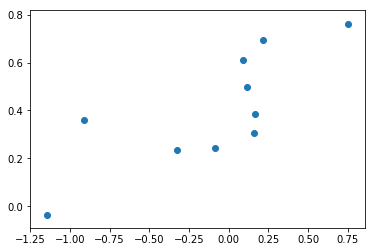

In [20]:
plt.scatter(x,y)

In [21]:
num_ratings_vs_movies = [0 for i in movie_dic.keys()]
for (i, j, yij) in lst:
    num_ratings_vs_movies[j] += 1
num_ratings_vs_movies = np.array(num_ratings_vs_movies)

In [22]:
indices = num_ratings_vs_movies.argsort()[-10:][::-1]

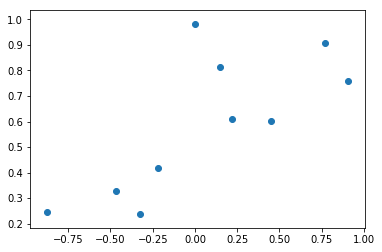

In [23]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

In [24]:
movie_rating_dic = {id: [] for id in movie_dic.keys()} # dic of movie id and ratings

for rating in lst:
    _, movie_id, r = rating
    movie_rating_dic[movie_id].append(r)

avg_ratings = {movie: sum(movie_rating_dic[movie]) / len(movie_rating_dic[movie]) \
               for movie in movie_rating_dic}

# get ten best movies that received highest average rating
top_10 = sorted(avg_ratings.items(), key=lambda tup: tup[1], reverse=True)[:10]
indices = [t[0] for t in top_10]

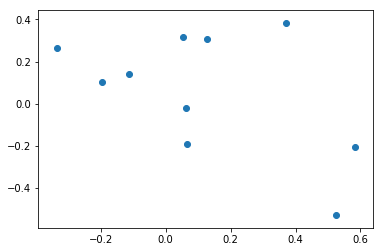

In [25]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

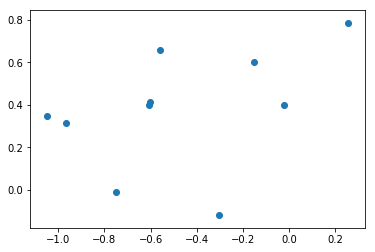

In [26]:
fant_movies = movie_genre_dic['Fantasy']
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

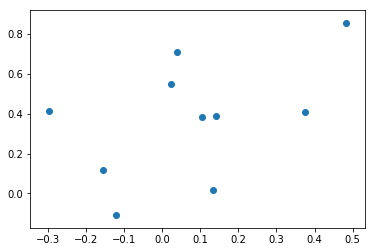

In [27]:
fant_movies = movie_genre_dic['Documentary']
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

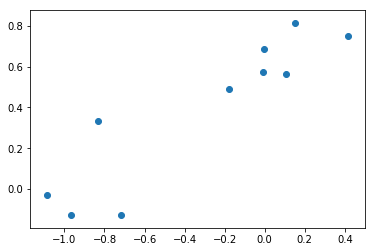

In [28]:
fant_movies = movie_genre_dic["Children's"]
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)